In [2]:
import cv2
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torchvision import transforms

## image preparation (binarization)

In [3]:
def im_prep(path):
    bgr_img = cv2.imread(path)
    gray = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
    #to find contours we need inverse binary image
    _,inv_bin = cv2.threshold(gray,140,255,cv2.THRESH_BINARY_INV)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(7,7))
    inv_bin_img = cv2.dilate(inv_bin,kernel)
    return bgr_img,inv_bin_img

## finding contours

In [4]:
def contours(inv_bin_img):
    contours,hier = cv2.findContours(inv_bin_img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    #we should short, because of sometimes there will some noise, or we just want order sometimes
    srt_cntrs_area = sorted(contours,key=cv2.contourArea,reverse=True)
    return srt_cntrs_area

## sorting according to the position (left-to-right)

In [5]:
def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
                                        key=lambda b: b[1][i], reverse=reverse))
    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)

## cropping the individual digits

In [6]:
def crop(bbox,bin_inv_img,bgr_img):
    cropped_bin_imgs = []
    cropped_bgr_imgs = []
    for box in bbox:
        x,y,w,h = box
        #crops the object according to the bbox coordinates
        #bins
        cropped_bin = bin_inv_img.copy()[y:y+h,x:x+w]
        cropped_bin_imgs.append(cropped_bin)
        #bgrs
        cropped_bgr = bgr_img.copy()[y:y+h,x:x+w]
        cropped_bgr_imgs.append(cropped_bgr)

    return cropped_bgr_imgs,cropped_bin_imgs


## padding(making square aspect ratio 1:1), resizing -> 28 x 28

In [7]:
def resizer(cropped_bin_imgs,gen_pad):
    p = gen_pad
    resized_imgs = []
    for cropped_bin in cropped_bin_imgs:
        (h,w) = cropped_bin.shape
        if w>h:
            diff = w-h
            top=0
            bottom=0
            #if difference is even, result will be integer, but else, we should fix it , because padding requires integer
            if diff%2==0:
                top = diff//2
                bottom = diff//2
            else:
                top = diff//2
                bottom = diff//2 + 1
            padded = cv2.copyMakeBorder(cropped_bin.copy(),top,bottom,0,0,cv2.BORDER_CONSTANT,(0,0,0))
        #elif if picture is taller
        elif w<h:
            diff = h-w
            right=0
            left=0
            #if difference is even, result will be integer, but else, we should fix it , because padding requires integer
            if diff%2==0:
                left = diff//2
                right = diff//2
            else:
                left = diff//2 + 1
                right = diff//2
            padded = cv2.copyMakeBorder(cropped_bin.copy(),0,0,left,right,cv2.BORDER_CONSTANT,(0,0,0))
        # we put some general padding
        padded = cv2.copyMakeBorder(padded,p,p,p,p,cv2.BORDER_CONSTANT,(0,0,0))
        resized = cv2.resize(padded.copy(),(28,28),interpolation=cv2.INTER_AREA)
        resized_imgs.append(resized)
    return resized_imgs

## transforming to tensor to feed the model

In [8]:
def image2model(resized_img):
    loader = transforms.Compose([transforms.ToTensor()])
    image = loader(resized_img)
    image = image.unsqueeze(0)
    return image


## loading trained model

In [9]:
def modeler(saved_params):
    class CNN(nn.Module):
        def __init__(self):
            super(CNN,self).__init__()
            self.conv1 = nn.Conv2d(1,8,kernel_size =(3,3),stride=(1,1),padding=(1,1))
            self.conv2 = nn.Conv2d(8,16,kernel_size =(3,3),stride=(1,1),padding=(1,1))
            self.pool = nn.MaxPool2d(kernel_size=(2,2),stride=(2,2))
            self.cf1 = nn.Linear(16*7*7,10)
        
        def forward(self,x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = x.view(x.shape[0],-1)
            x = self.cf1(x)
            
            return x
    model = CNN()
    model.load_state_dict(torch.load(saved_params))
    return model

## helper func to visualize cropped images

In [10]:
def visual(imgs):
    n = len(imgs)
    fig,ax = plt.subplots(1,n,figsize=(n*5,5))
    for i,img in enumerate(imgs):
        ax[i].imshow(img,cmap='gray')
        ax[i].axis('off')

## run

number written is : 5354198


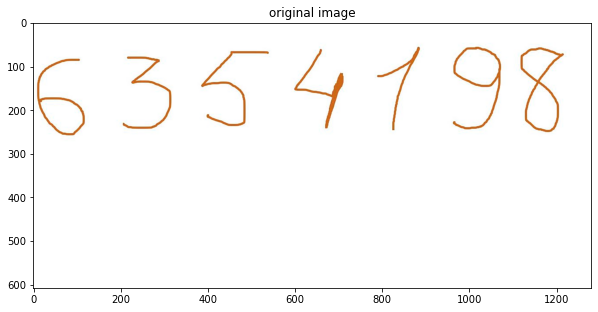

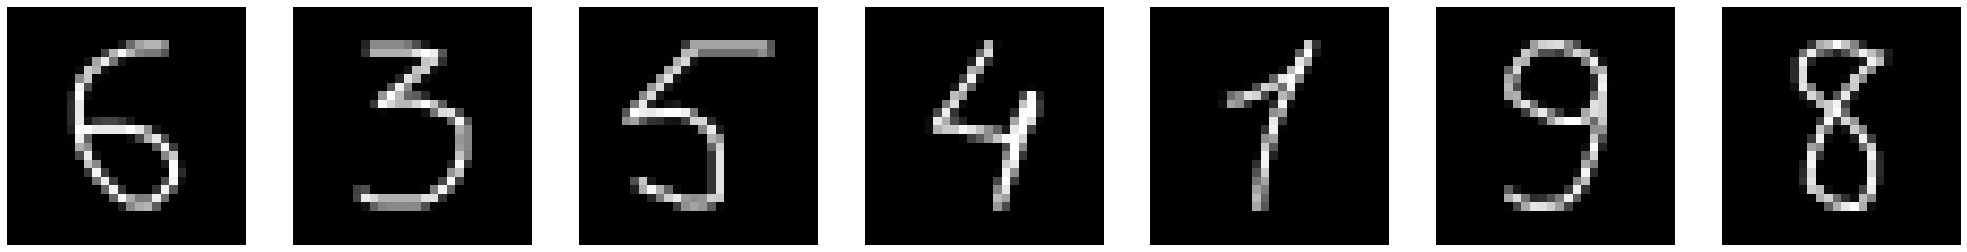

In [21]:
saved_model = 'model.pth'
image_path = 'images/4.jpg'
result=[]
def run(path,saved_model):
    #image load and image binarization
    bgr,inv_bin_img = im_prep(path)
    fig,ax = plt.subplots(1,figsize=(10,15))
    ax.imshow(bgr)
    ax.set_title('original image')
    #finding contours and sorting by area(to get only object but noise)
    srt_con_area = contours(inv_bin_img)
    #sorting by position and getting boudingrects
    cntrs,bbox = sort_contours(srt_con_area[:8])
    #cropping with bounding rects coordinates
    cropped_bgrs,cropped_bins = crop(bbox,inv_bin_img,bgr)
    #making aspect ratio 1:1 and resizing 28x28
    resized_imgs = resizer(cropped_bins,40)
    visual(resized_imgs)
    #input to feed the model
    for resized_img in resized_imgs:
        input = image2model(resized_img)
        #loading the model
        model = modeler(saved_model)
        #prediction
        pred = model(input)
        label = pred.argmax(dim=1).item()
        result.append(label)
    
    print(f'number written is :',''.join(str(digit) for digit in result))
    
run(image_path,saved_model)
    
    
